# Library imports and directory mount

In [1]:
!pip install -q kaggle
import matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns, tensorflow as tf
import cv2, gc, glob, joblib, os, random, sys, warnings, zipfile

from google.colab import drive

from tensorflow.keras.optimizers import AdamW
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from skimage.transform import resize

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight

warnings.filterwarnings('ignore')

sns.set() # for ploting

drive.mount('/content/gdrive')

tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
!python --version

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Python 3.10.12


In [2]:
!cp "/content/gdrive/MyDrive/PUC/TCC/Notebooks/preTreinados/kaggle.json" "."
!chmod 600 kaggle.json
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
with zipfile.ZipFile("/content/skin-cancer-mnist-ham10000.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

100% 5.20G/5.20G [03:56<00:00, 23.8MB/s]
100% 5.20G/5.20G [03:56<00:00, 23.6MB/s]


In [4]:
!mv /content/HAM10000_images_part_1/*.jpg /content/HAM10000_images_part_2

## Configuration variables

Index | Recommended configuration
:---: | :---:
1 | Rotation up to 20º<br>shear up to 15º<br>Horizontal and vertical flip<br>Vertical and horizontal shift up to 20%<br>Zoom out up to 20%
2 | Rotation up to 15º<br>Vertical and horizontal flip<br>Image resize up to 10%

In [2]:
#@title Configurations { display-mode: "form" }
#@markdown # Environment
csvMetadataPath = "/content/HAM10000_metadata.csv" #@param {type:"string"}
imagesPath = "/content/HAM10000_images_part_2/" #@param {type:"string"}
savePath = "/content/gdrive/MyDrive/PUC/TCC/Notebooks/" #@param {type:"string"}
saveName = "xceptionDataAugmentationTransf"        #@param {type:"string"}

#@markdown ## Model architecture
architecture = "xception"       #@param ["convNeXt", "resNetV2", "xception"]

#@markdown ## Height and weight of images to be crop
#h, w = 299,299                  #@param [[224,224],[299,299]]{type:"raw"}
#@markdown 299x299 if xception, else 224x224
if architecture == "xception":
    h, w = 299,299
else:
    h, w = 224,224
#@markdown ## Transfer learning from imagenet
transferLearning = True        #@param {type:"boolean"}
freezeLayers = True            #@param {type:"boolean"}

#@markdown ## Remove duplicates
#@markdown False = 10015 images, True = 7470 images
removeDuplicates = True         #@param {type:"boolean"}
balanceClasses = False           #@param {type:"boolean"}

#@markdown ## Segmentation
segmentation = False            #@param {type:"boolean"}

#@markdown ## Data augmentation
dataAugmentation = True        #@param {type:"boolean"}
rotation = .45                  #@param {type:"slider", min:0, max:3.6, step: 0.01}
widthShift = 0.1                #@param {type:"slider", min:0, max:3.6, step: 0.01}
heightShift = 0.1               #@param {type:"slider", min:0, max:3.6, step: 0.01}
channelShift = .15              #@param {type:"slider", min:0, max:0.5, step: 0.01}
shear = .2                      #@param {type:"slider", min:0, max:0.5, step: 0.01}
zoom = 0.05                     #@param {type:"slider", min:0, max:0.5, step: 0.01}
hFlip,vFlip = True,True         #@param ["True,True", "True,False", "False,True", "False,False"] {type:"raw"}
fill = 'nearest'                #@param ["constant", "nearest", "reflect", "wrap"]
#@markdown Case the previous is constant
cval = .5                       #@param {type:"slider", min:0, max:0.5, step: 0.01}
minBright = 0.1                 #@param [{type:"slider", min:0, max:1, step: 0.01}
maxBright = 1.1                 #@param [{type:"slider", min:1, max:2, step: 0.01}
bright = [minBright,maxBright]

#@markdown ### Normalization
featureCenter = False           #@param {type:"boolean"}
sampleCenter = False            #@param {type:"boolean"}
featureStdNorm = False          #@param {type:"boolean"}
sampleStdNorm = False           #@param {type:"boolean"}
zcaWhitening = False            #@param {type:"boolean"}
#@markdown ### Separate from imageDataGenerator
standardScalerNorm = False      #@param {type:"boolean"}
minMaxScalerNorm = False        #@param {type:"boolean"}

#@markdown ## Model configuration
epochs = 10                      #@param {type:"slider", min:1, max:100, step:1}
batchSize = 8                   #@param {type:"slider", min:1, max:64, step:1}
customOptimizer = False         #@param {type:"boolean"}
useCallback = False             #@param {type:"boolean"}

cancerType = {
    'akiec': 0, # 0.0 - 'Doenca de Bowens'
    'bcc': 1, # 1.0 - 'Carcinoma basocelular'
    'bkl': 2, # 2.0 - 'Keratose benigna'
    'df': 3, # 3.0 - 'Dermatofibroma'
    'vasc': 4, # 4.0 - 'Lesao vascular'
    'mel': 5, # 5.0 - 'Melanoma'
    'nv': 6  # 6.0 - 'Nevo melanocitico'
}
totalClasses = len(cancerType)

# Dataset import (CSV Metadata)

In [3]:
datasetMetadata = pd.read_csv(csvMetadataPath)
datasetMetadata = datasetMetadata.drop(columns=['dx_type','age','sex','localization']) # Non-utilized columns
datasetMetadata = datasetMetadata.rename(columns={"lesion_id": "lesionId",
                                                  "image_id": "imageId",
                                                  "dx": "cancerId"})
datasetMetadata.head()

,lesionId,imageId,cancerId
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0000118,ISIC_0025030,bkl
2,HAM_0002730,ISIC_0026769,bkl
3,HAM_0002730,ISIC_0025661,bkl
4,HAM_0001466,ISIC_0031633,bkl


In [4]:
datasetMetadata['duplicate'] = datasetMetadata['lesionId']      # Creating a column to indicate if the lesion has more than one image

uniqueLesions = datasetMetadata.groupby('lesionId').count()     # Counts the number of lesions for each id
uniqueLesions = uniqueLesions[uniqueLesions['imageId'] == 1]    # Filter lesions which ones have unique id
uniqueLesions.reset_index(inplace = True)                       # Add default index column
uniqueLesions = uniqueLesions['lesionId'].values.tolist()       # Extracts the indexes into a list

datasetMetadata['duplicate'] = datasetMetadata['lesionId'].apply(lambda x: False if x in uniqueLesions else True) # Fill the rows indicating if the lesion has a duplicated image
datasetMetadata['duplicate'].value_counts()
del uniqueLesions

Removing Duplicates

In [5]:
if removeDuplicates: # Adjusted to get only one of the duplicates and non duplicates
    datasetMetadata = datasetMetadata[~((datasetMetadata['lesionId'].duplicated()) & (datasetMetadata['duplicate']))]
datasetMetadata.head()

,lesionId,imageId,cancerId,duplicate
0,HAM_0000118,ISIC_0027419,bkl,True
2,HAM_0002730,ISIC_0026769,bkl,True
4,HAM_0001466,ISIC_0031633,bkl,True
6,HAM_0002761,ISIC_0029176,bkl,True
8,HAM_0005132,ISIC_0025837,bkl,True


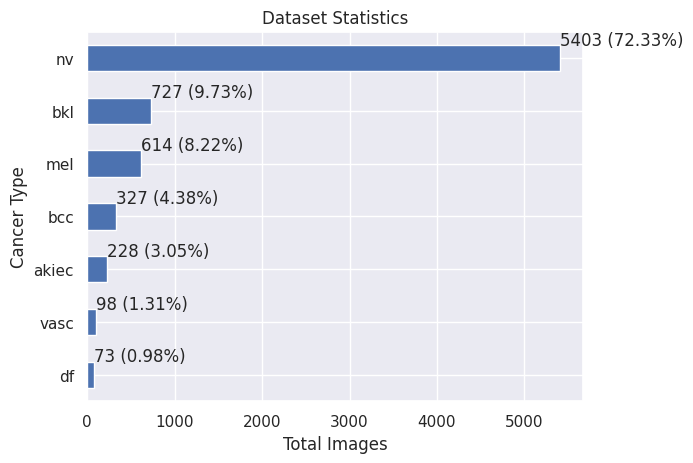

cancerId
df         73
vasc       98
akiec     228
bcc       327
mel       614
bkl       727
nv       5403
dtype: int64
Total:  7470


In [6]:
labelSize = datasetMetadata.groupby('cancerId').size().sort_values() # Sort and order every cancer class

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/datasetMetadata.shape[0]*100, 2)) + '%)') # Set the percentage of each cancer class
plt.title('Dataset Statistics')
plt.ylabel('Cancer Type')
plt.xlabel('Total Images')
plt.show()

print(labelSize)
print("Total: ", labelSize.sum())
del labelSize

In [7]:
datasetMetadata['cancerId'] = datasetMetadata['cancerId'].map(cancerType) # Map each class into an integer
datasetMetadata.head()

,lesionId,imageId,cancerId,duplicate
0,HAM_0000118,ISIC_0027419,2,True
2,HAM_0002730,ISIC_0026769,2,True
4,HAM_0001466,ISIC_0031633,2,True
6,HAM_0002761,ISIC_0029176,2,True
8,HAM_0005132,ISIC_0025837,2,True


# Dataset import (Imgs)

Path to the dataset images

"/content/gdrive/MyDrive/PUC/TCC/Datasets/ham10000/imgs/<imgId>.jpg"

In [8]:
images = []
loadedImages = 0

for index, row in datasetMetadata.iterrows():
    img = cv2.imread(''.join([imagesPath, row['imageId'], '.jpg'])) # Collect the image from drive
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                      # Invert color BGR => RGB
    img = cv2.resize(img, (h, w))                                   # Resize the image according to params provided
    images.append(img)

    loadedImages = loadedImages + 1
    if loadedImages % 1000 == 0:
        print(loadedImages)
del loadedImages, img

1000
2000
3000
4000
5000
6000
7000


7470
lesionId      HAM_0000118
imageId      ISIC_0027419
cancerId                2
duplicate            True
Name: 0, dtype: object
(299, 299, 3)


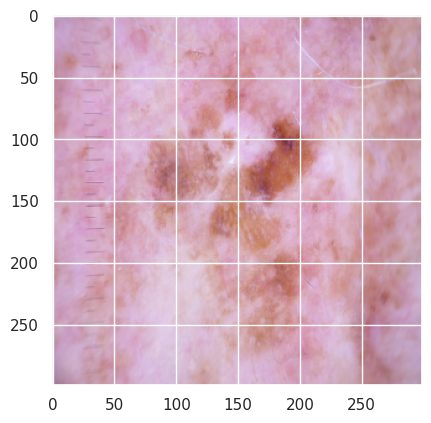

In [9]:
plt.imshow(images[0])
print(len(images))
print(datasetMetadata.iloc[0])
print(images[0].shape)
plt.show()

# Images treatment


1. Split train/val/test sets
1. Data augmentation (training set)
1. Segmentation (all sets)
1. Np array
1. Normalization (all sets, fit by training)
1. Reshape / toCategorical

Spliting in training, validation and test balancing the batches by the cancer id:

Train set = 70%

Validation set = 10%

Test set = 20%

In [10]:
XTrainVal, XTest, YTrainVal, YTest = train_test_split(images,
                                                      datasetMetadata['cancerId'],
                                                      test_size = 0.2,
                                                      train_size = 0.8,
                                                      stratify = datasetMetadata['cancerId'])
del images, datasetMetadata
XTrain, XVal, YTrain, YVal = train_test_split(XTrainVal,
                                              YTrainVal,
                                              test_size = 0.125,
                                              train_size = 0.875,
                                              stratify = YTrainVal)
del XTrainVal, YTrainVal

print('Train set size: ', YTrain.size)
print('Validation set size: ', YVal.size)
print('Test set size: ', YTest.size)

Train set size:  5229
Validation set size:  747
Test set size:  1494


Information of each class in every set

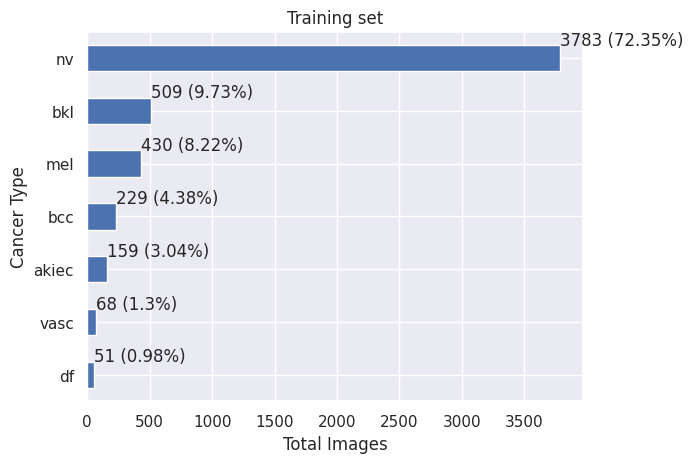

In [11]:
labelSize = YTrain.value_counts()
labelSize.index = labelSize.index.map(lambda x: list(cancerType.keys())[list(cancerType.values()).index(x)])
labelSize = labelSize.sort_values()

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/YTrain.shape[0]*100, 2)) + '%)')
plt.title('Training set')
plt.ylabel('Cancer Type')
plt.xlabel('Total Images')
plt.show()

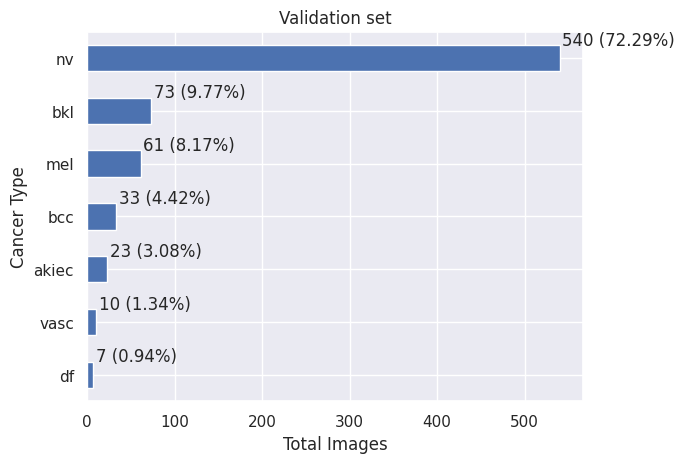

In [12]:
labelSize = YVal.value_counts()
labelSize.index = labelSize.index.map(lambda x: list(cancerType.keys())[list(cancerType.values()).index(x)])
labelSize = labelSize.sort_values()

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/YVal.shape[0]*100, 2)) + '%)')
plt.title('Validation set')
plt.ylabel('Cancer Type')
plt.xlabel('Total Images')
plt.show()

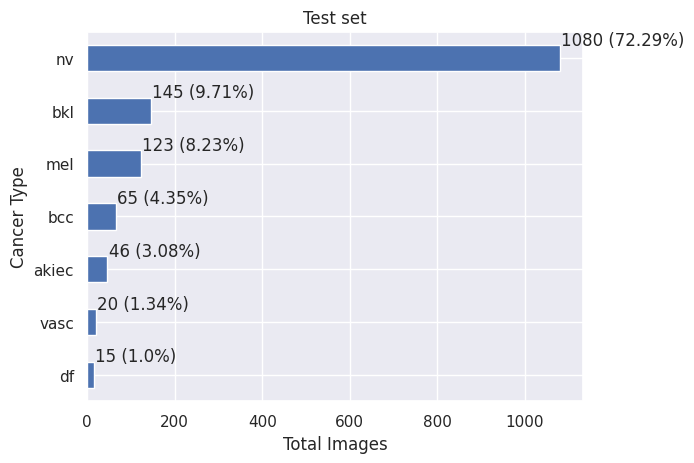

In [13]:
labelSize = YTest.value_counts()
labelSize.index = labelSize.index.map(lambda x: list(cancerType.keys())[list(cancerType.values()).index(x)])
labelSize = labelSize.sort_values()

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/YTest.shape[0]*100, 2)) + '%)')
plt.title('Test set')
plt.ylabel('Cancer Type')
plt.xlabel('Total Images')
plt.show()
del labelSize, ax

Data augmentation - Only be applied in the training set

Batchsize formula = round((class with most images / current class) - 1)

In [14]:
if dataAugmentation:
    datagen = ImageDataGenerator(
        # Normalizations
        featurewise_center = featureCenter,
        samplewise_center = sampleCenter,
        featurewise_std_normalization = featureStdNorm,
        samplewise_std_normalization = sampleStdNorm,
        zca_whitening = zcaWhitening,
        # Image modifications
        rotation_range = rotation,
        zoom_range = zoom,
        channel_shift_range = channelShift,
        fill_mode = fill,
        cval = cval,
        width_shift_range = widthShift,
        height_shift_range = heightShift,
        horizontal_flip = hFlip,
        brightness_range = bright,
        shear_range = shear,
        vertical_flip = vFlip
    )
    if featureCenter or featureStdNorm or zcaWhitening:
        datagen.fit(XTrain)

In [15]:
if dataAugmentation:
    batch_sizes = {
        0: 23,
        1: 15,
        2: 6,
        3: 73,
        4: 55,
        5: 9,
        6: 0
    }
    augmented_images = []
    augmented_labels = []
    for image, label in zip(XTrain, YTrain):
        augmented_images.append(image)
        augmented_labels.append(label)

        if batch_sizes[label] > 0:
            image = np.expand_dims(image, axis=0)  # 3D -> 4D
            augmented = datagen.flow(image, batch_size=batch_sizes[label]) # Generate the image batch

            for i in range(batch_sizes[label]): # Iterate over the batch and append the images
                augmented_images.append(np.squeeze(augmented.next(), axis=0).astype('uint8'))
                augmented_labels.append(label)

    XTrain = augmented_images
    YTrain = pd.Series(augmented_labels)
    del augmented_labels, augmented_images, batch_sizes

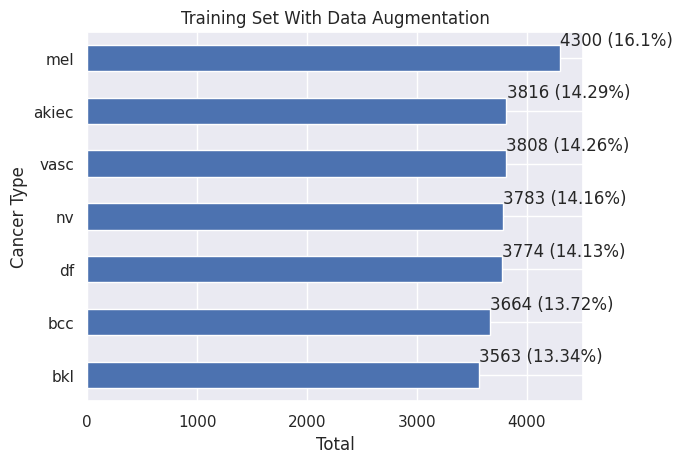

In [16]:
if dataAugmentation:
    labelSize = YTrain.value_counts()
    labelSize.index = labelSize.index.map(lambda x: list(cancerType.keys())[list(cancerType.values()).index(x)])
    labelSize = labelSize.sort_values()

    ax = labelSize.plot.barh()

    for i, v in enumerate(labelSize):
        ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/YTrain.shape[0]*100, 2)) + '%)')
    plt.title('Training Set With Data Augmentation')
    plt.ylabel('Cancer Type')
    plt.xlabel('Total')
    plt.show()
    del labelSize, ax

Segmentation

In [17]:
def segmentImg(img, alpha = 1.0, kernelMask = (5, 5), kernelSoftMask = (21, 21)):
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    softenedImg = cv2.GaussianBlur(grayImg, kernelMask, 0)                                # Apply softened filter to reduce noise
    _, mask = cv2.threshold(softenedImg, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) # Thresholding algorithm to create mask
    softenedMask = cv2.GaussianBlur(mask, kernelSoftMask, 0)                              # Smoothing filter
    segmentedImg = cv2.bitwise_and(img, img, mask = softenedMask)                         # Apply mask
    beta = 1.0 - alpha # Beta = weight for original image, alpha = Weight for segmented image - 0 for highlight only the lesion, 1 for original image
    return cv2.addWeighted(img, alpha, segmentedImg, beta, 0)                             # Merge segmented image and original image weighted

def segmentImgList(imgs):
    for i in range(len(imgs)):
        imgs[i] = segmentImg(imgs[i])
    return imgs

if segmentation:
    XTrain = segmentImgList(XTrain)
    XVal = segmentImgList(XVal)
    XTest = segmentImgList(XTest)

Transform datasets into np arrays

In [18]:
XTrain = np.array(XTrain)
XTrain = XTrain.reshape(XTrain.shape[0], h * w * 3) # 4d -> 2d

XVal = np.array(XVal)
XVal = XVal.reshape(XVal.shape[0], h * w * 3) # 4d -> 2d

XTest = np.array(XTest)
XTest = XTest.reshape(XTest.shape[0], h * w * 3) # 4d -> 2d

Normalization

In [19]:
if minMaxScalerNorm:
    minMaxScaler = MinMaxScaler()
    minMaxScaler.fit(np.asarray(XTrain))

    XTrain = minMaxScaler.transform(XTrain)
    XVal = minMaxScaler.transform(XVal)
    XTest = minMaxScaler.transform(XTest)
elif standardScalerNorm:
    standardScaler = StandardScaler()
    standardScaler.fit(np.asarray(XTrain))

    XTrain = standardScaler.transform(XTrain)
    XVal = standardScaler.transform(XVal)
    XTest = standardScaler.transform(XTest)

print(np.shape(XTest))
print(np.shape(XTrain))
print(np.shape(XVal))
print(YTrain.head())

(1494, 268203)
(26708, 268203)
(747, 268203)
0    6
1    5
2    5
3    5
4    5
dtype: int64


Resize and input adaptation

In [20]:
print(XTrain.shape[0])
print(XVal.shape[0])
print(XTest.shape[0])

XTrain = XTrain.reshape(XTrain.shape[0], h, w, 3).astype('float32')
XVal = XVal.reshape(XVal.shape[0], h, w, 3).astype('float32')
XTest = XTest.reshape(XTest.shape[0], h, w, 3).astype('float32')

YTrain = np_utils.to_categorical(YTrain)
YVal = np_utils.to_categorical(YVal)
YTest = np_utils.to_categorical(YTest)

print(XTrain[0].shape)
XTrain.dtype

26708
747
1494
(299, 299, 3)


dtype('float32')

# Model training

Loading pre treined model

In [21]:
with tf.device('/GPU:0'): # Using GPU processing on model
    match architecture:
        case "convNeXt":
            model = tf.keras.applications.ConvNeXtBase(classes = totalClasses,
                                                       include_top = False,
                                                       input_shape = (h,w,3),
                                                       weights = 'imagenet' if transferLearning else None)
        case "resNetV2":
            model = tf.keras.applications.ResNet50V2(classes = totalClasses,
                                                     include_top = False,
                                                     input_shape = (h,w,3),
                                                     weights = 'imagenet' if transferLearning else None)
        case "xception":
            model = tf.keras.applications.Xception(classes = totalClasses,
                                                   include_top = False,
                                                   input_shape = (h,w,3),
                                                   weights = 'imagenet' if transferLearning else None)
        case _:
            raise Exception("model not configured or non existent")

    if freezeLayers:
        for layer in model.layers:
            layer.trainable = False

    model = tf.keras.Model(inputs = model.input,
                           outputs = tf.keras.layers.Dense(totalClasses,
                                                           activation = 'softmax')(tf.keras.layers.Flatten()(model.output)))

    if customOptimizer:
        model.compile(optimizer = AdamW(amsgrad = True,
                          beta_1 = 0.9 if transferLearning else 0.8,
                          beta_2 = 0.999 if transferLearning else 0.99,
                          learning_rate = 0.00001 if transferLearning else 0.001,
                          weight_decay = 0.04 if dataAugmentation else 0.0004),
                      loss = "categorical_crossentropy",
                      metrics = [tf.keras.metrics.Accuracy(),
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Recall(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.FalsePositives(),
                                 tf.keras.metrics.FalseNegatives(),
                                 tf.keras.metrics.TrueNegatives(),
                                 tf.keras.metrics.TruePositives()])
    else:
        model.compile(optimizer = "adam",
                      loss = "categorical_crossentropy",
                      metrics = [tf.keras.metrics.Accuracy(),
                                 tf.keras.metrics.AUC(),
                                 tf.keras.metrics.Recall(),
                                 tf.keras.metrics.Precision(),
                                 tf.keras.metrics.FalsePositives(),
                                 tf.keras.metrics.FalseNegatives(),
                                 tf.keras.metrics.TrueNegatives(),
                                 tf.keras.metrics.TruePositives()])

83683744/83683744 [==============================] - 5s 0us/step


In [22]:
gc.collect()
plt.close('all')

Training the model

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(batch_size = batchSize,
                        callbacks = [EarlyStopping(min_delta = 0.001, monitor = 'val_loss', patience=3)] if useCallback else None,
                        class_weight = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',
                                                                                        classes = np.unique(YTrain.argmax(axis=1)),
                                                                                        y = YTrain.argmax(axis=1)))) if balanceClasses else None,
                        epochs = epochs,
                        validation_data = (XVal, YVal),
                        verbose = 2,
                        x = XTrain,
                        y = YTrain)

Epoch 1/10
3339/3339 - 46s - loss: 454.9258 - accuracy: 0.8055 - auc: 0.6681 - recall: 0.4287 - precision: 0.4287 - false_positives: 15259.0000 - false_negatives: 15259.0000 - true_negatives: 144989.0000 - true_positives: 11449.0000 - val_loss: 456.2418 - val_accuracy: 0.8845 - val_auc: 0.7765 - val_recall: 0.6158 - val_precision: 0.6158 - val_false_positives: 287.0000 - val_false_negatives: 287.0000 - val_true_negatives: 4195.0000 - val_true_positives: 460.0000 - 46s/epoch - 14ms/step
Epoch 2/10
3339/3339 - 38s - loss: 396.3682 - accuracy: 0.8422 - auc: 0.7232 - recall: 0.5234 - precision: 0.5234 - false_positives: 12730.0000 - false_negatives: 12730.0000 - true_negatives: 147518.0000 - true_positives: 13978.0000 - val_loss: 574.0607 - val_accuracy: 0.9017 - val_auc: 0.8079 - val_recall: 0.6693 - val_precision: 0.6693 - val_false_positives: 247.0000 - val_false_negatives: 247.0000 - val_true_negatives: 4235.0000 - val_true_positives: 500.0000 - 38s/epoch - 11ms/step
Epoch 3/10
3339/33

In [24]:
del XTrain, YTrain
gc.collect()

1534

# Statistics

General eficiency

In [25]:
YPredicted = model.predict(XTest)
print('Test set evaluation: ', model.evaluate(XTest, YTest, verbose = 0))
print('Validation set evaluation: ', model.evaluate(XVal, YVal, verbose = 0))

47/47 [==============================] - 3s 33ms/step
Test set evaluation:  [691.5744018554688, 0.9106903672218323, 0.8224539756774902, 0.6954484581947327, 0.6954484581947327, 455.0, 455.0, 8509.0, 1039.0]
Validation set evaluation:  [741.8839721679688, 0.906674325466156, 0.813364565372467, 0.6800535321235657, 0.6800535321235657, 239.0, 239.0, 4243.0, 508.0]


Training epochs statistics

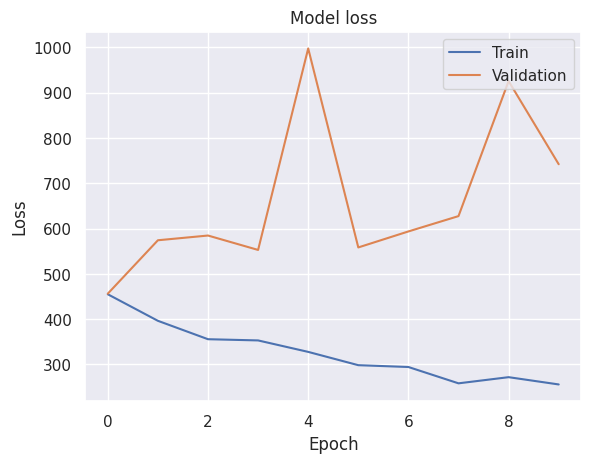

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

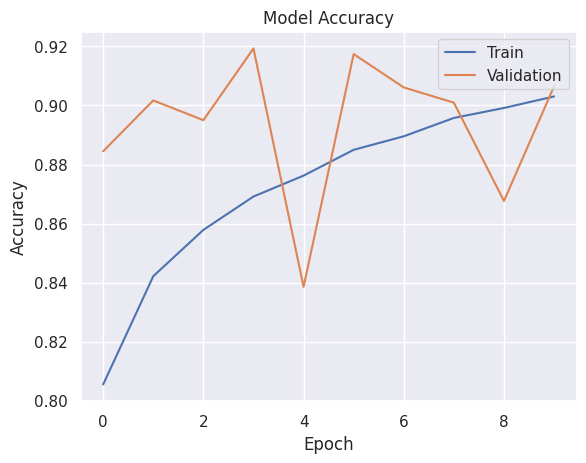

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

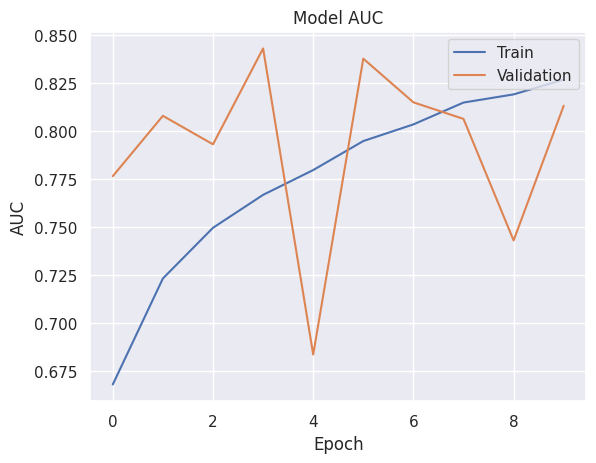

In [28]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

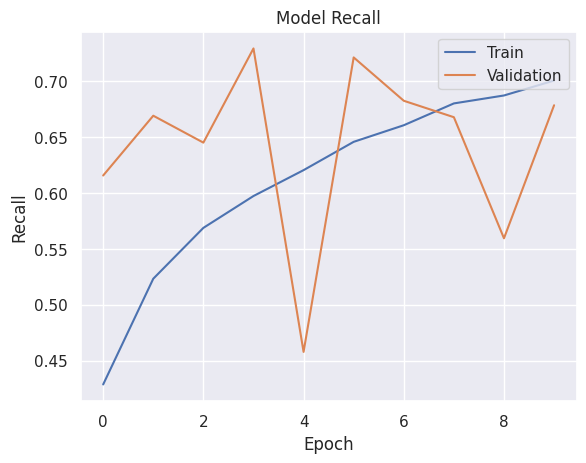

In [29]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

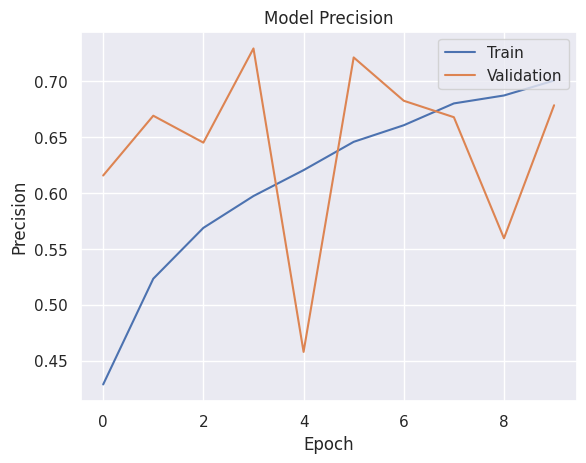

In [30]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

Confusion matrix

11646

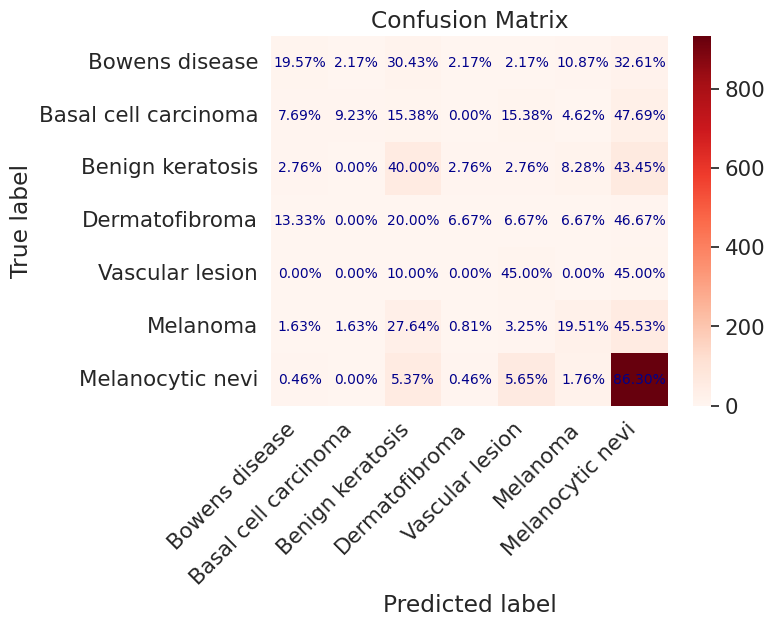

In [31]:
cm = confusion_matrix(YTest.argmax(axis = 1), YPredicted.argmax(axis = 1))

labels = ['Bowens disease',
          'Basal cell carcinoma',
          'Benign keratosis',
          'Dermatofibroma',
          'Vascular lesion',
          'Melanoma',
          'Melanocytic nevi']
dfCm = pd.DataFrame(cm, index = labels, columns = labels)

sns.set(font_scale = 1.4) # Label size
sns.heatmap(dfCm, annot = False, cmap = "Reds", annot_kws = {"size": 14}) # Font size

for i in range(totalClasses):
    for j in range(totalClasses):
        text = plt.text(j + 0.5, i + 0.5, f"{cm[i, j] / cm[i].sum() * 100:.2f}%", # {cm[i, j]:0d} ({cm[i, j] / cm[i].sum() * 100:.2f}%)
                        va = "center",
                        ha = "center",
                        color = "darkBlue",
                        fontsize = 10)

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right')

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
del ax, cm, dfCm
gc.collect()

Metrics

In [32]:
metrics = {
    'Precision': precision_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1), average=None),
    'F1-score': f1_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1), average=None),
    'ROC AUC': roc_auc_score(YTest, YPredicted, average=None),
    'Recall': recall_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1), average=None)
}

cmMulti = multilabel_confusion_matrix(YTest.argmax(axis=1), YPredicted.argmax(axis=1))
specificity = []
for i in range(len(cmMulti)):
    tn = cmMulti[i][0][0]
    specificity.append(tn / (tn + cmMulti[i][0][1]))
metrics[f'Specificity'] = specificity

metrics[f'Confusion_Matrix'] = cmMulti
del cmMulti, specificity

Precision:

       Label            Value  
      Bowens disease  0.333333 
Basal cell carcinoma  0.666667 
    Benign keratosis  0.324022 
      Dermatofibroma  0.083333 
     Vascular lesion  0.100000 
            Melanoma  0.375000 
    Melanocytic nevi  0.837376 


F1-score:

       Label            Value  
      Bowens disease  0.246575 
Basal cell carcinoma  0.162162 
    Benign keratosis  0.358025 
      Dermatofibroma  0.074074 
     Vascular lesion  0.163636 
            Melanoma  0.256684 
    Melanocytic nevi  0.849977 


ROC AUC:

       Label            Value  
      Bowens disease  0.612021 
Basal cell carcinoma  0.552813 
    Benign keratosis  0.668751 
      Dermatofibroma  0.529615 
     Vascular lesion  0.697083 
            Melanoma  0.594445 
    Melanocytic nevi  0.716361 


Recall:

       Label            Value  
      Bowens disease  0.195652 
Basal cell carcinoma  0.092308 
    Benign keratosis  0.400000 
      Dermatofibroma  0.066667 
     Vascular lesion  0.

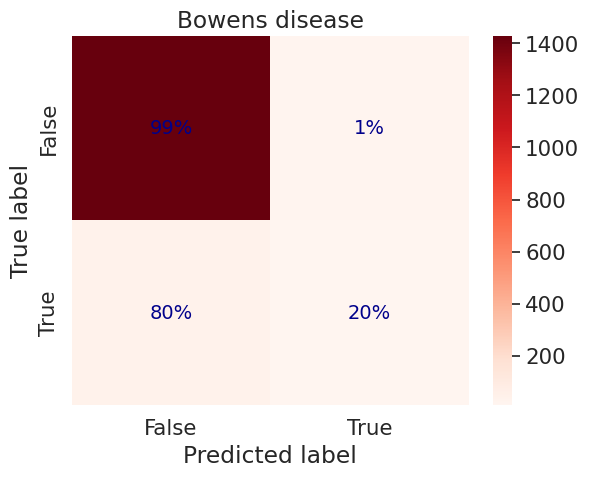

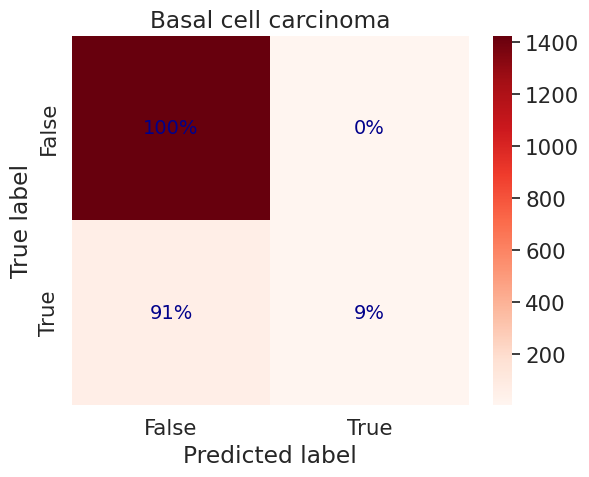

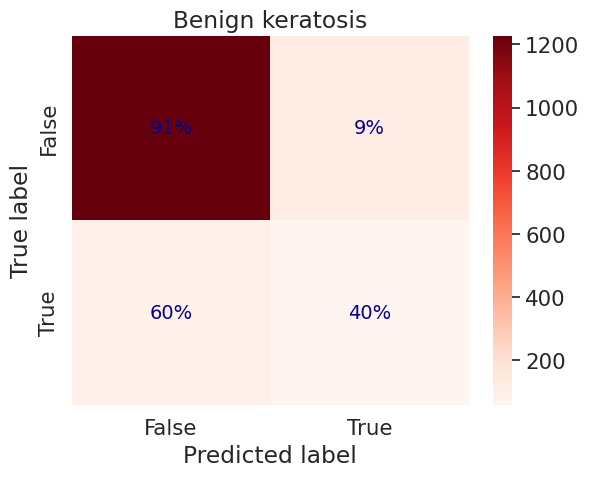

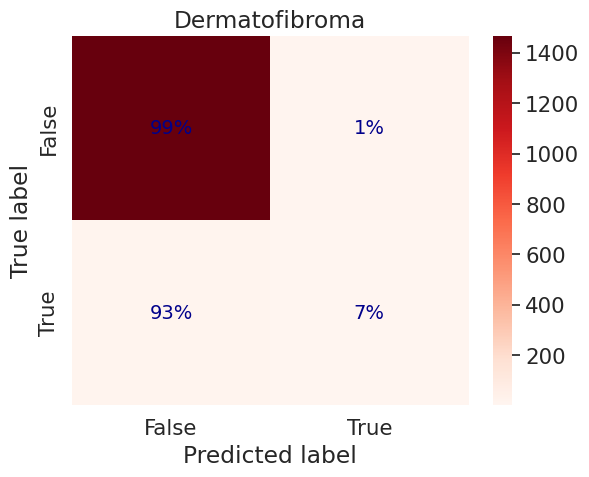

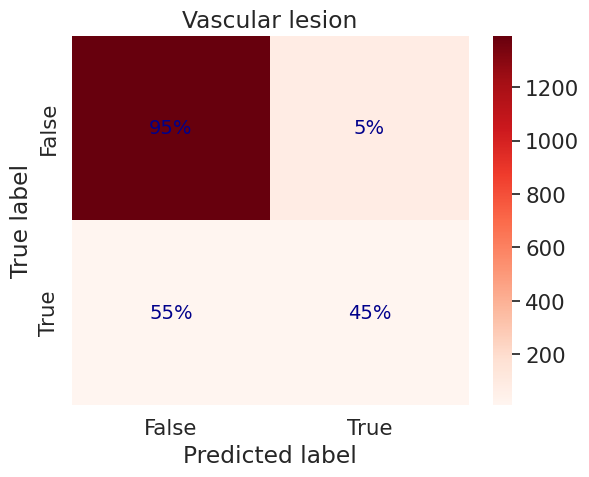

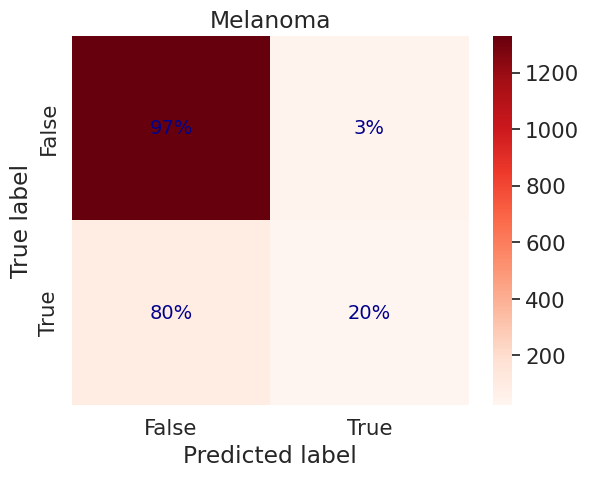

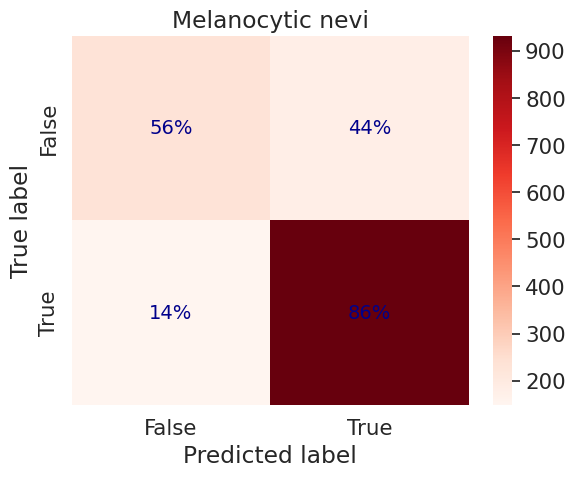

In [33]:
for metric, values in metrics.items():
    print(metric + ':\n')
    if 'Confusion_Matrix' in metric:
        for id, value in enumerate(values):
          sns.set(font_scale = 1.4) # Label size
          percentages = value / np.sum(value, axis = 1, keepdims = True)
          sns.heatmap(value, annot = False, cmap = "Reds")
          ax = plt.gca()
          for i in range(len(value)):
              for j in range(len(value)):
                  ax.text(j + 0.5, i + 0.5, f'{percentages[i, j]*100:.0f}%', # {value[i, j]:0d} ({percentages[i, j]*100:.0f}%)
                          ha = 'center',
                          va = 'center',
                          color = 'darkBlue',
                          fontsize = 14)
          ax.set_yticklabels(['False', 'True'])
          ax.set_xticklabels(['False', 'True'])
          plt.title(f'{labels[id]}')
          plt.ylabel('True label')
          plt.xlabel('Predicted label')
          plt.show()
    else:
        for id, value in enumerate(values):
            df = pd.DataFrame({'Label': labels, 'Value': values})
        print(df.to_string(index = False, col_space = 10, justify = 'center'))
    print('\n')

Saving model into google drive

In [34]:
model.save(''.join([savePath, saveName, '.h5']))
if minMaxScalerNorm:
    joblib.dump(minMaxScaler, ''.join([savePath, saveName, 'MMscaler.pkl']))
elif standardScalerNorm:
    joblib.dump(standardScaler, ''.join([savePath, saveName, 'StdScaler.pkl']))